In [61]:
import pandas as pd
import numpy as np
from glob import glob
import json

In [62]:
company_dict = {}
for f in glob("stock-price-predictions/tweet/*"):
    company = f.split("/")[-1]
    company_dict[company] = 0
    for day_f in glob(f + "/*"):
        data = []
        with open(day_f, 'r') as f:
            for line in f:
                data.append(json.loads(line))
        tweet_df = pd.DataFrame(data)
        company_dict[company] += tweet_df.shape[0]

company_dict = {k: v for k, v in sorted(company_dict.items(), key=lambda item: item[1], reverse=True)}
print(company_dict)

KeyboardInterrupt: 

<Axes: xlabel='Date'>

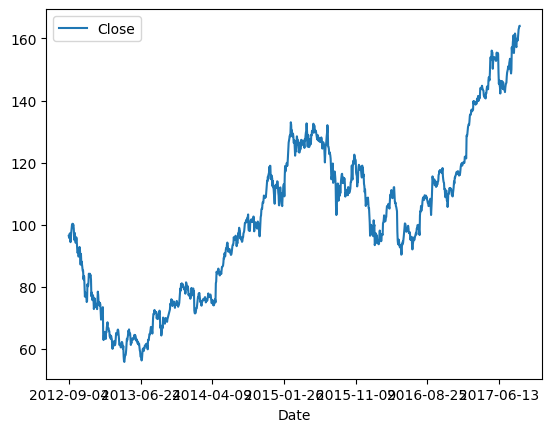

In [63]:
google_df = pd.read_csv("stock-price-predictions/price/AAPL.csv")

google_df.plot.line(x='Date', y='Close')

In [64]:
apple_tweet_df = pd.DataFrame()

for day_f in glob("stock-price-predictions/tweet/AAPL/*"):
    data = []
    with open(day_f, 'r') as f:
        for line in f:
            data.append(json.loads(line))
    tweet_df = pd.DataFrame(data)
    apple_tweet_df = pd.concat([apple_tweet_df, tweet_df])
    
apple_tweet_df = apple_tweet_df.reset_index(drop=True)

In [65]:
import torch
device = 0 if torch.cuda.is_available() else -1

In [66]:
from transformers import pipeline
sentiment_pipeline = pipeline(model="finiteautomata/bertweet-base-sentiment-analysis", batch_size=100, device=device)

c:\Users\lachl\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lachl\.cache\huggingface\hub\models--finiteautomata--bertweet-base-sentiment-analysis. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
All model checkpoint layers were used when initializing TFRobertaF

In [67]:
def analyze_sentiment(text_tokens_list):
    # for each row in column, join the text tokens together into a single string
    texts = [' '.join(text_tokens) for text_tokens in text_tokens_list]
    # apply the sentiment analysis to the entire list
    results = sentiment_pipeline(texts)
    # extract labels and scores for each result
    sentiments = [(res['label'], res['score']) for res in results]
    
    return sentiments

In [68]:
sentiment_df = pd.DataFrame(analyze_sentiment(apple_tweet_df['text']), columns=['sentiment', 'score'])

tweet_df = pd.concat([apple_tweet_df, sentiment_df], axis=1)

In [70]:
tweet_df.to_csv("stock-price-predictions/tweet/AAPL/tweet_sentiment.csv", index=False)